In [69]:
from datasets import load_dataset
import json
import requests
from bs4 import BeautifulSoup, Comment
from bs4 import Tag
from collections import deque
from sklearn.metrics.pairwise import cosine_similarity
from groq import Groq
import os
similarity = cosine_similarity

In [2]:
ds = load_dataset(
    "google-research-datasets/natural_questions", "dev", split="validation"
)

In [166]:
for i in range(10):
    print(ds[i]["document"]["title"])
    print(ds[i]["document"]["url"])

Wave–particle duality
https://en.wikipedia.org//w/index.php?title=Wave%E2%80%93particle_duality&amp;oldid=837021290
Current members of the United States Senate
https://en.wikipedia.org//w/index.php?title=Current_members_of_the_United_States_Senate&amp;oldid=822209735
Deposition (phase transition)
https://en.wikipedia.org//w/index.php?title=Deposition_(phase_transition)&amp;oldid=832599453
Longest word in English
https://en.wikipedia.org//w/index.php?title=Longest_word_in_English&amp;oldid=818685520
NBA All-Star Game Most Valuable Player Award
https://en.wikipedia.org//w/index.php?title=NBA_All-Star_Game_Most_Valuable_Player_Award&amp;oldid=831162386
Water distribution on Earth
https://en.wikipedia.org//w/index.php?title=Water_distribution_on_Earth&amp;oldid=837043390
Who Wants to Be a Millionaire? New Zealand
https://en.wikipedia.org//w/index.php?title=Who_Wants_to_Be_a_Millionaire%3F_New_Zealand&amp;oldid=742185609
Brock
https://en.wikipedia.org//w/index.php?title=Brock&amp;oldid=8163

In [3]:
i = 4

sample1 = ds[i]["document"]["html"]
ques1 = ds[i]["question"]["text"]
token_list1 = ds[i]["document"]["tokens"]
short_answer = ds[i]["annotations"]
long_answer = ds[i]["long_answer_candidates"]

'<!DOCTYPE html>\n<HTML class="client-js ve-not-available" lang="en" dir="ltr"><HEAD>\n\n<TITLE>NBA All-Star Game Most Valuable Player Award - Wikipedia</TITLE>\n\n\n<LINK rel="stylesheet" href="/w/load.php?debug=false&amp;lang=en&amp;modules=ext.cite.styles%7Cext.uls.interlanguage%7Cext.visualEditor.desktopArticleTarget.noscript%7Cext.wikimediaBadges%7Cmediawiki.legacy.commonPrint%2Cshared%7Cmediawiki.sectionAnchor%7Cmediawiki.skinning.interface%7Cskins.vector.styles%7Cwikibase.client.init&amp;only=styles&amp;skin=vector" />\n\n<STYLE>\n.referencetooltip{position:absolute;list-style:none;list-style-image:none;opacity:0;font-size:12px;margin:0;z-index:5;padding:0}.referencetooltip > li{background:#fff;border:1px solid #bbb;-webkit-box-shadow:0 0 10px rgba(0,0,0,0.2);-moz-box-shadow:0 0 10px rgba(0,0,0,0.2);box-shadow:0 0 10px rgba(0,0,0,0.2);margin:0;padding:8px 10px;line-height:18px;max-width:300px}.referencetooltip > li + li{box-sizing:border-box;margin-left:7px;margin-top:-1px;borde
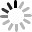

In [6]:
sample1

In [6]:
long_answer.keys()

dict_keys(['start_token', 'end_token', 'start_byte', 'end_byte', 'top_level'])

In [7]:
for candidate in zip(
    long_answer["start_token"],
    long_answer["end_token"],
    long_answer["start_byte"],
    long_answer["end_byte"],
    long_answer["top_level"],
):
    start_byte, end_byte = candidate[2], candidate[3]
    start_token, end_token = candidate[0], candidate[1]
    if candidate[4] is True:
        print(start_byte, end_byte, start_token, end_token)

        print(sample1[start_byte:end_byte])
        print(token_list1["token"][start_token], token_list1["token"][end_token])

131573 132771 26 130
<P>The identity of the <B>longest word in English</B> depends upon the <A href="/wiki/Definition" title="Definition">definition</A> of what constitutes a <A href="/wiki/Word" title="Word">word</A> in the <A href="/wiki/English_language" title="English language">English language</A>, as well as how length should be compared. In addition to words derived naturally from <A href="/wiki/History_of_English" title="History of English">the language&#39;s roots</A> (without any known intentional invention), English allows <A href="/wiki/New_words" class="mw-redirect" title="New words">new words</A> to be formed by <A href="#Coinages">coinage</A> and <A href="#Constructions">construction</A>; <A href="#Place_names">place names</A> may be considered words; <A href="#Technical_terms">technical terms</A> may be arbitrarily long. Length may be understood in terms of <A href="/wiki/Orthography" title="Orthography">orthography</A> and number of written <A href="/wiki/Letter_(alpha

In [210]:
sample2 = """<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>More Complex Example</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            line-height: 1.6;
            margin: 20px;
        }
        .container {
            max-width: 800px;
            margin: 0 auto;
            padding: 20px;
            border: 1px solid #ccc;
        }
        h1, h2 {
            color: #333;
        }
        p {
            margin-bottom: 15px;
        }
        ul {
            list-style-type: disc;
            padding-left: 20px;
        }
        a {
            color: blue;
            text-decoration: none;
        }
        a:hover {
            text-decoration: underline;
        }
        #important {
            font-weight: bold;
            color: red;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Welcome to My Website</h1>
        <p>This is a more detailed example with additional content and styling. We're exploring various HTML elements and CSS properties.</p>

        <h2>Section 1: Introduction</h2>
        <p>This section provides an overview of the topic. We'll discuss key concepts and provide context.</p>
        <ul>
            <li>Point 1: A key feature.</li>
            <li>Point 2: Another important aspect.</li>
            <li>Point 3: A supporting detail.</li>
        </ul>

        <h2>Section 2: Further Details</h2>
        <p>Here, we delve deeper into the subject matter. You can find more information and examples below.</p>
        <p id="important">This is an important paragraph with special styling.</p>
        <a href="https://www.example.com">Visit Example Website</a>

        <div>
          <h3>A Sub Section</h3>
          <p>Some more text here</p>
          <img src="dummy_image.jpg" alt="Dummy Image" width="300">
        </div>
    </div>
</body>
</html>"""

In [4]:
class BlockNode:
    def __init__(self, tag, attributes=None, content=None):
        self.tag = tag
        self.path = []
        self.attributes = attributes or {}
        self.content = content.strip() if content else ""
        self.children = []
        self.block = ""
        self.is_leaf = False
        self.embedding = None

    def add_child(self, child):
        self.children.append(child)

    def to_dict(self):
        return {
            "tag": self.tag,
            "attributes": self.attributes,
            "content": self.content,
            "children": [child.to_dict() for child in self.children],
        }

In [5]:
def clean_html(html_content):
    # Parse the HTML content
    soup = BeautifulSoup(html_content, "html.parser")

    # Step 1: HTML Content Cleaning
    # Remove <script>, <style>, and comments
    for tag in soup(["script", "style"]):
        tag.decompose()
    for comment in soup.find_all(string=lambda text: isinstance(text, Comment)):
        comment.extract()

    # Remove lengthy attributes (e.g., inline styles, large data attributes)
    def clean_attributes(tag):
        for attr in list(tag.attrs.keys()):
            if len(str(tag[attr])) > 50:  # Arbitrary threshold for "lengthy"
                del tag[attr]

    for tag in soup.find_all(True):  # All tags
        clean_attributes(tag)

    # Step 2: Lossless Structural Compression
    # Merge single-nested tags
    def merge_single_nested_tags(tag):
        while (
            len(tag.contents) == 1
            and isinstance(tag.contents[0], Tag)
            and tag.contents[0].name == tag.name
        ):
            child = tag.contents[0]
            tag.attrs.update(child.attrs)  # Merge attributes
            tag.contents = child.contents  # Replace contents
        for child in tag.find_all(recursive=False):
            merge_single_nested_tags(child)

    # Remove all \t and \n in the data
    for text in soup.find_all(string=True):
        text.replace_with(text.replace("\n", "").replace("\t", ""))
    for tag in soup.find_all(True):  # All tags
        merge_single_nested_tags(tag)

    # Remove empty tags
    for tag in soup.find_all():
        if not tag.contents or all(
            str(content).strip() == "" for content in tag.contents
        ):
            tag.decompose()

    return soup

In [6]:
def build_dom_tree(html_content):
    def build_tree(element):
        if not element.name:
            return None

        # Create a BlockNode for the current element
        node = BlockNode(
            tag=element.name,
            attributes=element.attrs,
            content=element.get_text(strip=True) if element.string else "",
        )
        
        # Recursively process children
        for child in element.children:
            child_node = build_tree(child)
            if child_node:
                node.add_child(child_node)

        return node

    root = build_tree(html_content)
    return root

In [12]:
def build_block_tree(dom_tree: BlockNode, max_window: int):
    """
    Construct a Block Tree from a DOM Tree.

    Args:
        dom_tree (BlockNode): The root of the DOM tree.
        max_window (int): The maximum token limit for a block.

    Returns:
        BlockNode: The root of the constructed Block Tree.
    """

    def merge_children_content(node: BlockNode, max_window):
        """Merge content of children nodes."""
        grand_children = []
        child_block = []
        for child in node.children:
            # print(child.tag, child.content)
            grand_children.extend(child.children)
            if child.content.strip():
                child_block.append(f"{child.content}")
            print(child_block)
        if not grand_children:
            temp_block = " ".join(child_block)
            new_child_content = split_content(temp_block, max_window)
            if len(new_child_content) == 1:
                node.children = []
                return []
            # print("=============\n",new_child_content)
            node.children = []
            for idx, content in enumerate(new_child_content):
                node.add_child(BlockNode(tag=f"{node.tag}_{idx}", content=content))
            for child in node.children:
                child.is_leaf = True
                child.path = node.path.copy().append(child.tag)
                print(child.path)
            return node.children
        # If the total content of children is less than the max window, add it to the block
        # print(max_window)
        if len(" ".join(child_block)) < max_window:
            node.block += " ".join(child_block)
            print(node.block)
            node.children = grand_children.copy()
            return merge_children_content(
                node, max_window - len(node.block) - 1
            )
        return node.children

    def split_content(content, max_window):
        """Split content into chunks within the token limit."""
        tokens = content.split()
        return [
            " ".join(tokens[i : i + max_window])
            for i in range(0, len(tokens), max_window)
        ]
    def retag_dom_tree(node: BlockNode, tag_counts=None):

        if tag_counts is None:
            tag_counts = {"[document]": 0}
        tag_prefix = ''.join(filter(str.isalpha, node.tag)) if node.tag else ''
        if tag_prefix not in tag_counts:
            tag_counts[tag_prefix] = 0

        tag_counts[tag_prefix] += 1
        node.tag = f"{tag_prefix}{tag_counts[tag_prefix]}"
        node.path.append(node.tag)
        print(node.path)

        for child in node.children:
            child.path = node.path.copy()
            print(child.path)
            retag_dom_tree(node = child, tag_counts = tag_counts)

    def build_block_tree_bfs(root: BlockNode, max_window):
        queue = deque([root])
        while queue:
            node = queue.popleft()
            if not node.children:
                node.block = node.content if node.content.strip() else ""
                node.is_leaf = True
                continue
            node.block = node.content if node.content.strip() else ""
            print("Block content: ", node.block)
            if len(node.block) < max_window:
                merge_children_content(node, max_window - len(node.block) - 1)
                if not node.children:
                    node.is_leaf = True
                else:
                    queue.extend(node.children)
                    node.is_leaf = False
            else:
                queue.extend(node.children)
                node.is_leaf = False

        return root
    retag_dom_tree(dom_tree)
    # print_tree_blocks(dom_tree, with_path=True)
    new_tree = build_block_tree_bfs(dom_tree, max_window)
    return new_tree

In [51]:
def print_tree_blocks(node: BlockNode, indent: int = 0, with_path = False):
    """Print the block tree."""
    if with_path is True:
        print("    " * indent + f"{node.block}", end="")
        if node.path != []:
            print(node.path)
        else:
            print("dont have path")
    else:
        print("    " * indent + f"{node.block}")
    for child in node.children:
        print_tree_blocks(child, indent + 1, with_path)

In [8]:
def print_tree_contents(node: BlockNode, depth=0):
    """Print tree structure with tag and block contents."""
    if not node:
        return
    print("  " * depth + f"Tag: {node.tag}, Content: {node.content}, {node.attributes}")
    for child in node.children:
        # print(child.content)
        print_tree_contents(child, depth + 1)

In [22]:
def sth(node: BlockNode):
    if not node:
        return
    if node.path == []:
        print(node.block)
    else:
        print(node.path)
    for child in node.children:
        sth(child)

In [ ]:
sth(tree)

In [9]:
print_tree_contents(tree)

NameError: name 'tree' is not defined

In [60]:
content = clean_html(sample1)
# content.find_all()
dom_tree = build_dom_tree(content)
# print_tree_contents(dom_tree)
tree = build_block_tree(dom_tree, 500)
print_tree_blocks(tree, with_path=True)

['document1']
['document1']
['document1', 'html1']
['document1', 'html1']
['document1', 'html1', 'head1']
['document1', 'html1', 'head1']
['document1', 'html1', 'head1', 'title1']
['document1', 'html1']
['document1', 'html1', 'body1']
['document1', 'html1', 'body1']
['document1', 'html1', 'body1', 'div1']
['document1', 'html1', 'body1', 'div1']
['document1', 'html1', 'body1', 'div1', 'div2']
['document1', 'html1', 'body1', 'div1', 'div2']
['document1', 'html1', 'body1', 'div1', 'div2', 'div3']
['document1', 'html1', 'body1', 'div1', 'div2', 'div3']
['document1', 'html1', 'body1', 'div1', 'div2', 'div3', 'a1']
['document1', 'html1', 'body1', 'div1']
['document1', 'html1', 'body1', 'div1', 'h1']
['document1', 'html1', 'body1', 'div1']
['document1', 'html1', 'body1', 'div1', 'div4']
['document1', 'html1', 'body1', 'div1', 'div4']
['document1', 'html1', 'body1', 'div1', 'div4', 'div5']
['document1', 'html1', 'body1', 'div1', 'div4']
['document1', 'html1', 'body1', 'div1', 'div4', 'div6']
[

In [36]:
EMB_MODEL_ID = "text-embedding-nomic-embed-text-v1.5"


def fetch_embedding(text):
    """Fetch embedding for a given text from LMStudio."""
    try:
        url = "http://localhost:9999/v1/embeddings"
        data = {"model": EMB_MODEL_ID, "input": text}
        headers = {"Content-Type": "application/json"}
        response = requests.post(url, headers=headers, data=json.dumps(data))
        if response.status_code == 200:
            # print(response.json())
            return response.json()["data"]
        else:
            print(response.text)
    except requests.exceptions.RequestException as e:
        print(f"Error querying LMStudio: {e}")
        return None

In [37]:
def tree_contents(root):
    contents = []
    if not root:
        return contents
    if root.block.strip():
        contents.append(root.block)
    for child in root.children:
        child_content = tree_contents(child)
        child_content = [content for content in child_content if content.strip()]
        contents.extend(child_content)
    return contents

In [38]:
def print_tree_embeddings(node: BlockNode, depth=0):
    """Print tree structure with embeddings."""
    if not node:
        return
    # if node.content.strip():
    print(
        "  " * depth
        + f"Tag: {node.tag}, Text: {node.block}, Embeddings: {node.embedding}"
    )
    for child in node.children:
        print_tree_embeddings(child, depth + 1)

In [39]:
def embed_contents(root: BlockNode, contents):
    embd = fetch_embedding(contents)

    # print(len(embd))
    def tranverse_tree(root: BlockNode, idx):
        if not root:
            return
        if root.block.strip():
            root.embedding = embd[idx]["embedding"]
            # print(root.content, idx, root.embedding)
            idx += 1
        for child in root.children:
            idx = tranverse_tree(child, idx)
            # print(idx)
        return idx

    tranverse_tree(root, 0)

In [40]:
contents_to_embd = tree_contents(tree)

In [41]:
print(len(" ".join(contents_to_embd).split()), len(contents_to_embd))

1653 610


In [61]:
embed_contents(tree, contents_to_embd)

In [43]:
contents_to_embd

['NBA All-Star Game Most Valuable Player Award - Wikipedia',
 'NBA All-Star Game Most Valuable Player Award',
 'From Wikipedia, the free encyclopedia',
 'navigation',
 'search',
 'Championship Individual awards HonorsChampionship',
 'hide',
 'National Basketball Association',
 'awards and honors',
 "O'Brien Trophy",
 'All-Star Game MVP',
 'Bill Russell Finals MVP',
 'Coach of the Year',
 'Defensive Player of the Year',
 'Executive of the Year',
 'J. Walter Kennedy Citizenship',
 'Community Assist Award',
 'Most Improved Player',
 'Most Valuable Player',
 'Rookie of the Year',
 'Sixth Man of the Year',
 'Sportsmanship Award',
 'Twyman–Stokes Teammate of the Year',
 'Lifetime Achievement Award',
 'All-NBA Team All-Rookie Team All-Defensive Team',
 'v t ev t e',
 'National Basketball Association All-Star Game Most Valuable Player',
 'MVP',
 'National Basketball Association',
 'All-Star Game',
 '1953',
 'Ed Macauley',
 'Paul Arizin',
 '1951',
 '1952',
 '[1]',
 '[2]',
 'lockout',
 '[3]',
 '

In [44]:
ques_embd = fetch_embedding(ques1)[0]["embedding"]

In [62]:
def similarity_compute(node: BlockNode, ques_embd, total_sim, max_sim, min_sim):
    if not node:
        return
    if node.embedding is not None:
        cosine_sim = similarity([node.embedding], [ques_embd])[0][0]
        print(cosine_sim, node.block if cosine_sim > 0.2 else None)
        max_sim = max(max_sim, cosine_sim)
        min_sim = min(min_sim, cosine_sim)
        total_sim += cosine_sim

    for child in node.children:
        max_sim, min_sim, total_sim = similarity_compute(
            child, ques_embd, total_sim, max_sim, min_sim
        )
    return max_sim, min_sim, total_sim

In [63]:
max_sim, min_sim, total_sim = similarity_compute(tree, ques_embd, 0.0, 0.0, 1.0)
print(max_sim, min_sim, total_sim / len(contents_to_embd))

0.7198302026980402 NBA All-Star Game Most Valuable Player Award - WikipediaNBA All-Star Game Most Valuable Player Award Navigation menuFrom Wikipedia, the free encyclopedia This page was last edited on 19 March 2018, at 02:49. Privacy policy About Wikipedia Disclaimers Contact Wikipedia Developers Cookie statement Mobile view Enable previews
0.7858279482179847 navigation
0.37644209014932994 search
0.37848988158472696 Championship Individual awards HonorsChampionshiphide National Basketball Association awards and honorsv t ev t ev t e
0.4840654255256446 O'Brien Trophy
0.6051853601429953 All-Star Game MVP Bill Russell Finals MVP Coach of the Year Defensive Player of the Year Executive of the Year J. Walter Kennedy Citizenship Community Assist Award
0.328571983168987 Most Improved Player Most Valuable Player Rookie of the Year Sixth Man of the Year Sportsmanship Award Twyman–Stokes Teammate of the Year Lifetime Achievement Award
0.4777456376566327 All-NBA Team All-Rookie Team
0.5889067132

In [47]:
ques1

'who has the most all star mvp awards'

In [48]:
def pruning_tree_on_similarity(node: BlockNode, ques_embd, threshold):
    if not node:
        return None
    if node.embedding is not None:
        cosine_sim = similarity([node.embedding], [ques_embd])[0][0]

        pruned_children = []

        for child in node.children:
            pruned_child = pruning_tree_on_similarity(child, ques_embd, threshold)
            if pruned_child is not None:
                pruned_children.extend(pruned_child)

        if cosine_sim < threshold:
            return pruned_children if pruned_children else None

        node.children = pruned_children
        return [node]
    return node.children

In [64]:
pruning_tree_on_similarity(tree, ques_embd, total_sim / len(contents_to_embd) * 0.9)

In [65]:
print_tree_blocks(tree, with_path=True)

NBA All-Star Game Most Valuable Player Award - WikipediaNBA All-Star Game Most Valuable Player Award Navigation menuFrom Wikipedia, the free encyclopedia This page was last edited on 19 March 2018, at 02:49. Privacy policy About Wikipedia Disclaimers Contact Wikipedia Developers Cookie statement Mobile view Enable previews['document1']
    navigation['document1', 'html1', 'body1', 'div1', 'div4', 'div6', 'a2']
    search['document1', 'html1', 'body1', 'div1', 'div4', 'div6', 'a3']
    Championship Individual awards HonorsChampionshiphide National Basketball Association awards and honorsv t ev t ev t e['document1', 'html1', 'body1', 'div1', 'div4', 'div7', 'div8', 'table1', 'tbody1']
        O'Brien Trophy['document1', 'html1', 'body1', 'div1', 'div4', 'div7', 'div8', 'table1', 'tbody1', 'tr3', 'td1', 'div9', 'table2', 'tbody2', 'tr4', 'td2', 'ul1']
        ['document1', 'html1', 'body1', 'div1', 'div4', 'div7', 'div8', 'table1', 'tbody1', 'tr3', 'td1', 'div9', 'table2', 'tbody2', 'tr4'

In [82]:
def tree_blocks_to_string(node: BlockNode, indent: int = 0) -> str:
    """Convert the block tree to a string."""
    if not node:
        return ""
    result = "    " * indent + f"<{node.tag}>{node.block}\n"
    for child in node.children:
        result += tree_blocks_to_string(child, indent + 1)
    return result


# Convert the tree blocks to a string
tree_blocks_str = tree_blocks_to_string(tree)

In [67]:
def get_node_paths_and_contents(node: BlockNode, path="") -> list:
    """Return a list containing each node path and node block content."""
    if not node:
        return []
    
    current_path = f"<{node.path[-1]}>"
        
    result = [{"path": current_path, "content": node.block}]
    
    if not node.block.strip():
        result.pop()
    for child in node.children:
        result.extend(get_node_paths_and_contents(child, current_path))
    return result

# Get the list of node paths and contents
node_paths_and_contents = get_node_paths_and_contents(tree)

node_paths_and_contents_zip = [[node_paths_and_contents[0]['path']+node_paths_and_contents[0]['content']]]
for path in node_paths_and_contents[1:]:
    if len(path["path"]) + len(path["content"]) < 1000 - len(''.join(node_paths_and_contents_zip[-1])):
        node_paths_and_contents_zip[-1].append(path["path"]+path["content"])
    else:
        node_paths_and_contents_zip.append([path["path"]+path["content"]])
node_paths_and_contents_zip

[['<document1>NBA All-Star Game Most Valuable Player Award - WikipediaNBA All-Star Game Most Valuable Player Award Navigation menuFrom Wikipedia, the free encyclopedia This page was last edited on 19 March 2018, at 02:49. Privacy policy About Wikipedia Disclaimers Contact Wikipedia Developers Cookie statement Mobile view Enable previews',
  '<a2>navigation',
  '<a3>search',
  '<tbody1>Championship Individual awards HonorsChampionshiphide National Basketball Association awards and honorsv t ev t ev t e',
  "<ul1>O'Brien Trophy",
  '<ul3>All-Star Game MVP Bill Russell Finals MVP Coach of the Year Defensive Player of the Year Executive of the Year J. Walter Kennedy Citizenship Community Assist Award',
  '<ul4>Most Improved Player Most Valuable Player Rookie of the Year Sixth Man of the Year Sportsmanship Award Twyman–Stokes Teammate of the Year Lifetime Achievement Award',
  '<ul5>All-NBA Team All-Rookie Team',
  '<ul6>All-Defensive Team',
  '<b1>National Basketball Association All-Star G

In [66]:
def count_nodes(node: BlockNode) -> int:
    if not node:
        return 0
    count = 1  # Count the current node
    for child in node.children:
        count += count_nodes(child)
    return count


# Count the number of nodes in the latest tree
num_nodes = count_nodes(tree)
print(f"Number of nodes in the tree: {num_nodes}")

Number of nodes in the tree: 728


In [86]:
CHAT_MODEL_ID = "mistral-7b-instruct-v0.3"


def fetch_irrelevent(html_content, question, min_items):
    """Fetch a joke response from LMStudio."""
    try:
        url = "http://127.0.0.1:9999/v1/chat/completions"
        data = {
            "model": CHAT_MODEL_ID,
            "messages": [
                {
                    "role": "system",
                    "content": """
                    You are an expert system designed to evaluate and prune irrelevant or redundant HTML content. Your task is to process an HTML document and retain only the text blocks that are directly or indirectly relevant to a given question. 
                    Text is considered relevant if it:\n
                        1. Provides a direct answer to the question.\n
                        2. Supplies evidence or details that support answering the question.\n
                        3. Offers necessary context for understanding the answer.\n
                    Avoid retaining blocks that:\n
                        1. Are completely unrelated to the question.\n
                        2. Contain redundant or repetitive information.\n
                        3. Discuss general information not connected to the topic.\n
                    You should output only a path to the relevant blocks, preserving the original structure.
                    Input: **HTML**: {HTML tag and content}. **Question**: {Question}. **Output**: {List of text blocks path that relevant}
                    ### Example
                    **Output**: ["{<html1><title1>, Relevant Title}", "{<html1><body1><p3>, Relevant Information}"]
                    """,
                },
                {
                    "role": "user",
                    "content": f"**HTML**: “{html_content}”\n**Question**: **{question}**",
                },
            ],
            "response_format": {
                "type": "json_schema",
                "json_schema": {
                    "name": "TextBlocks",
                    "schema": {
                        "type": "object",
                        "properties": {
                            "paths": {
                                "type": "array",
                                "items": {
                                    "type": "object",
                                    "properties": {
                                        "path": {"type": "string"},
                                    },
                                    "required": [
                                        "path",
                                    ]
                                },
                                "minItems": min_items,
                            }
                        },
                        "required": ["paths"]
                    }
                }
            },
            "temperature": 0.2,
            "stream": False,
        }
        headers = {"Content-Type": "application/json"}
        response = requests.post(url, headers=headers, data=json.dumps(data))

        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error: {response.status_code} - {response.text}")
    except requests.exceptions.RequestException as e:
        print(f"Error querying LMStudio: {e}")
        return None


In [ ]:
client = Groq(
    # This is the default and can be omitted
    api_key=os.getenv("GROQ_API"),
)


def inference(html_content, question, min_items):
    json_schema = {
        "type": "object",
        "properties": {
            "paths": {
                "type": "array",
                "items": {
                    "type": "object",
                    "properties": {
                        "path": {"type": "string"},
                    },
                    "required": [
                        "path",
                    ],
                },
                "minItems": min_items,
            }
        },
        "required": ["paths"],
    }
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": """
            You are an expert system designed to evaluate and prune irrelevant or redundant HTML content. Your task is to process an HTML document and retain only the text blocks that are directly or indirectly relevant to a given question. 
            Text is considered relevant if it:\n
                1. Provides a direct answer to the question.\n
                2. Supplies evidence or details that support answering the question.\n
                3. Offers necessary context for answering the question.\n
            Avoid retaining blocks that:\n
                1. Are completely unrelated to the question.\n
                2. Contain redundant or repetitive information.\n
                3. Discuss general information not connected to the topic.\n
                4. Duplicate information that has already been provided in other blocks the question.\n
            You should output only a path to the relevant blocks, preserving the original structure.
            Input: 
            **HTML**: {HTML tag and content}. 
            **Question**: {Question}. 
            **Output**: {A JSON object containing a list of text blocks path and their relevant text}.
            ### Example
            **Output**: ["{"path": <html1><title1>, "text": Relevant Title}", "{"path": <body1><p3>, "text": Relevant Information}"]
            """
            },
            {
                "role": "user",
                "content": f"**HTML**: “{html_content}”\n**Question**: **{question}**.Output in JSON format",
            }
        ],
        response_format={
                "type": "json_object",  # Use 'json_object' as the allowed type
                "json_object": {
                    "paths": [
                        {
                            "path": "string",  # Define the expected structure of the JSON object,
                            "text": "string"
                        }
                    ]
                },
        },
        model="llama-3.1-8b-instant",
        temperature=0.2,
        stream=False,
    )

    print(chat_completion.choices[0].message.content)
    return chat_completion.choices[0].message.content

In [ ]:
raw_answer = []
for path in node_paths_and_contents_zip:
    min_items = min(len(path), 5)
    path_response = inference(path, ques1, min_items)
    if path_response:
        raw_answer.append(path_response)


{
   "relevant_blocks": [
      {
         "path": "<document1><tbody1>",
         "text": "Individual awards Honors"
      },
      {
         "path": "<document1><ul3>",
         "text": "All-Star Game MVP Bill Russell"
      },
      {
         "path": "<document1><ul3>",
         "text": "Coach of the Year Defensive Player of the Year Executive of the Year J. Walter Kennedy Citizenship Community Assist Award"
      },
      {
         "path": "<document1><ul4>",
         "text": "All-Star Game MVP"
      },
      {
         "path": "<document1><b1>",
         "text": "National Basketball Association All-Star Game Most Valuable Player"
      },
      {
         "path": "<document1><b2>",
         "text": "MVP"
      }
   ]
}
{
   "relevant_blocks": [
      {
         "path": "<html1><a30>All-Star Game",
         "text": "All-Star Game"
      },
      {
         "path": "<html1><a87>Adrian Smith",
         "text": "Adrian Smith"
      },
      {
         "path": "<html1><a88>Jerry We

In [74]:
for path in final_path_list:
    print(path)

{'path': '<document1><tbody1>', 'text': 'Individual awards Honors'}
{'path': '<document1><ul3>', 'text': 'All-Star Game MVP Bill Russell'}
{'path': '<document1><ul3>', 'text': 'Coach of the Year Defensive Player of the Year Executive of the Year J. Walter Kennedy Citizenship Community Assist Award'}
{'path': '<document1><ul4>', 'text': 'All-Star Game MVP'}
{'path': '<document1><b1>', 'text': 'National Basketball Association All-Star Game Most Valuable Player'}
{'path': '<document1><b2>', 'text': 'MVP'}
{'path': '<html1><a30>All-Star Game', 'text': 'All-Star Game'}
{'path': '<html1><a87>Adrian Smith', 'text': 'Adrian Smith'}
{'path': '<html1><a88>Jerry West', 'text': 'Jerry West'}
{'path': '<html1><a89>Tom Chambers', 'text': 'Tom Chambers'}
{'path': '<html1><a81>Oscar Robertson', 'text': 'Oscar Robertson'}
{'path': '<html1><a82>Willis Reed', 'text': 'Willis Reed'}
{'path': '<html1><a83>Dave Cowens', 'text': 'Dave Cowens'}
{'path': '<html1><a84>Allen Iverson', 'text': 'Allen Iverson'}
{'

In [97]:
final_path_list = []
for path in raw_answer:
    final_path_list.extend(json.loads(path)["relevant_blocks"])
# for path in final_path_list:
#     print(path)

In [98]:
for path in final_path_list:
    element = path["path"].split(">")
    miss_parse = 0
    if len(element) > 1:
        for elem in element[:-1]:
            if not elem.startswith("<"):
                print(path["text"], elem)
                path["text"] = path["text"] + elem if elem not in path["text"] else ""
            else:
                miss_parse += 1
        # print(element, miss_parse)
        path["text"] += (" " + element[-1]) if element[-1] not in path["text"] else ""
        path["path"] = element[miss_parse - 1] + ">"
    print(path)

{'path': '<tbody1>', 'text': 'Individual awards Honors'}
{'path': '<ul3>', 'text': 'All-Star Game MVP Bill Russell'}
{'path': '<ul3>', 'text': 'Coach of the Year Defensive Player of the Year Executive of the Year J. Walter Kennedy Citizenship Community Assist Award'}
{'path': '<ul4>', 'text': 'All-Star Game MVP'}
{'path': '<b1>', 'text': 'National Basketball Association All-Star Game Most Valuable Player'}
{'path': '<b2>', 'text': 'MVP'}
{'path': '<a30>', 'text': 'All-Star Game'}
{'path': '<a87>', 'text': 'Adrian Smith'}
{'path': '<a88>', 'text': 'Jerry West'}
{'path': '<a89>', 'text': 'Tom Chambers'}
{'path': '<a81>', 'text': 'Oscar Robertson'}
{'path': '<a82>', 'text': 'Willis Reed'}
{'path': '<a83>', 'text': 'Dave Cowens'}
{'path': '<a84>', 'text': 'Allen Iverson'}
{'path': '<a85>', 'text': 'NBA Most Valuable Player Award'}
{'path': '<a87>', 'text': 'Adrian Smith'}
{'path': '<div14>', 'text': 'Contents'}
{'path': '<span15>', 'text': 'Winners'}
{'path': '<th17>', 'text': 'Pettit, Bob

In [99]:
for path in final_path_list:
    print(path)
    if "text" in path.keys():
        embd = fetch_embedding(path["text"])
    else:
        embd = fetch_embedding(path["path"])
    if embd:
        simi_score = similarity([embd[0]["embedding"]], [ques_embd])[0][0]
        print(simi_score if simi_score > 0.1 else None)

{'path': '<tbody1>', 'text': 'Individual awards Honors'}
0.5820152157063229
{'path': '<ul3>', 'text': 'All-Star Game MVP Bill Russell'}
0.7205569120219945
{'path': '<ul3>', 'text': 'Coach of the Year Defensive Player of the Year Executive of the Year J. Walter Kennedy Citizenship Community Assist Award'}
0.6068957016434715
{'path': '<ul4>', 'text': 'All-Star Game MVP'}
0.8078514316948476
{'path': '<b1>', 'text': 'National Basketball Association All-Star Game Most Valuable Player'}
0.7712663799589677
{'path': '<b2>', 'text': 'MVP'}
0.7678527741648714
{'path': '<a30>', 'text': 'All-Star Game'}
0.6864700770627946
{'path': '<a87>', 'text': 'Adrian Smith'}
0.45202821645726576
{'path': '<a88>', 'text': 'Jerry West'}
0.3412529712842708
{'path': '<a89>', 'text': 'Tom Chambers'}
0.3670188548460145
{'path': '<a81>', 'text': 'Oscar Robertson'}
0.4685611894128575
{'path': '<a82>', 'text': 'Willis Reed'}
0.39615827049576785
{'path': '<a83>', 'text': 'Dave Cowens'}
0.25545022517724064
{'path': '<a84

In [56]:
short_answer

{'id': ['16561957862311810757',
  '9013765907572342552',
  '17009528298897439994',
  '1543919103567142329',
  '12851569555955771450'],
 'long_answer': [{'start_token': 449,
   'end_token': 759,
   'start_byte': 64455,
   'end_byte': 68310,
   'candidate_index': 40},
  {'start_token': 449,
   'end_token': 759,
   'start_byte': 64455,
   'end_byte': 68310,
   'candidate_index': 40},
  {'start_token': 449,
   'end_token': 759,
   'start_byte': 64455,
   'end_byte': 68310,
   'candidate_index': 40},
  {'start_token': 449,
   'end_token': 759,
   'start_byte': 64455,
   'end_byte': 68310,
   'candidate_index': 40},
  {'start_token': 3326,
   'end_token': 3606,
   'start_byte': 156131,
   'end_byte': 160678,
   'candidate_index': 121}],
 'short_answers': [{'start_token': [450, 453],
   'end_token': [452, 455],
   'start_byte': [64504, 64571],
   'end_byte': [64514, 64582],
   'text': ['Bob Pettit', 'Kobe Bryant']},
  {'start_token': [450, 453],
   'end_token': [452, 455],
   'start_byte': [6